*<h3>Data Loading</h3>*

In [235]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.ensemble import RandomForestRegressor

In [236]:
df = pd.read_csv('supermarket-sales.csv')
df

,Order ID,Customer Name,Category,Subcategory,City,Orderdate,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu
...,...,...,...,...,...,...,...,...,...,...,...
9989,OD9990,Sudeep,"Eggs, Meat & Fish",Eggs,Madurai,12/24/2015,West,945,0.16,359.10,Tamil Nadu
9990,OD9991,Alan,Bakery,Biscuits,Kanyakumari,07-12-2015,West,1195,0.26,71.70,Tamil Nadu
9991,OD9992,Ravi,Food Grains,Rice,Bodi,06-06-2017,West,1567,0.16,501.44,Tamil Nadu
9992,OD9993,Peer,Oil & Masala,Spices,Pudukottai,10/16/2018,West,1659,0.15,597.24,Tamil Nadu


*<h3>Preprocessing</h3>*
**1.Removing_useless_columns**

In [237]:
df = df.drop('State', axis=1)
df = df.drop('Customer Name', axis=1)
df = df.drop('Discount', axis=1)
df = df.drop('Order ID', axis=1)

**2.Fetching_day_month_year_and_dropping_date**

In [238]:
df['Orderdate'] = pd.to_datetime(df['Orderdate'], format='mixed', dayfirst=True, errors='coerce')
df['day'] = df['Orderdate'].dt.day
df['month'] = df['Orderdate'].dt.month
df['year'] = df['Orderdate'].dt.year
df =df.drop('Orderdate', axis=1)
df

,Category,Subcategory,City,Region,Sales,Profit,day,month,year
0,Oil & Masala,Masalas,Vellore,North,1254,401.28,11,8,2017
1,Beverages,Health Drinks,Krishnagiri,South,749,149.80,11,8,2017
2,Food Grains,Atta & Flour,Perambalur,West,2360,165.20,6,12,2017
3,Fruits & Veggies,Fresh Vegetables,Dharmapuri,South,896,89.60,10,11,2016
4,Food Grains,Organic Staples,Ooty,South,2355,918.45,10,11,2016
...,...,...,...,...,...,...,...,...,...
9989,"Eggs, Meat & Fish",Eggs,Madurai,West,945,359.10,24,12,2015
9990,Bakery,Biscuits,Kanyakumari,West,1195,71.70,7,12,2015
9991,Food Grains,Rice,Bodi,West,1567,501.44,6,6,2017
9992,Oil & Masala,Spices,Pudukottai,West,1659,597.24,16,10,2018


**3.Unique_Values**

In [239]:
print(len(df.Category.unique()), 
      len(df.Subcategory.unique()), 
      len(df.Region.unique()), 
      len(df.year.unique()))

7 23 5 4


**4.Null_value_checking**

In [240]:
df.isna().sum()

Category       0
Subcategory    0
City           0
Region         0
Sales          0
Profit         0
day            0
month          0
year           0
dtype: int64

*<h3>Visualizing</h3>*

array([[<Axes: title={'center': 'Sales'}>,
        <Axes: title={'center': 'Profit'}>],
       [<Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'year'}>, <Axes: >]], dtype=object)

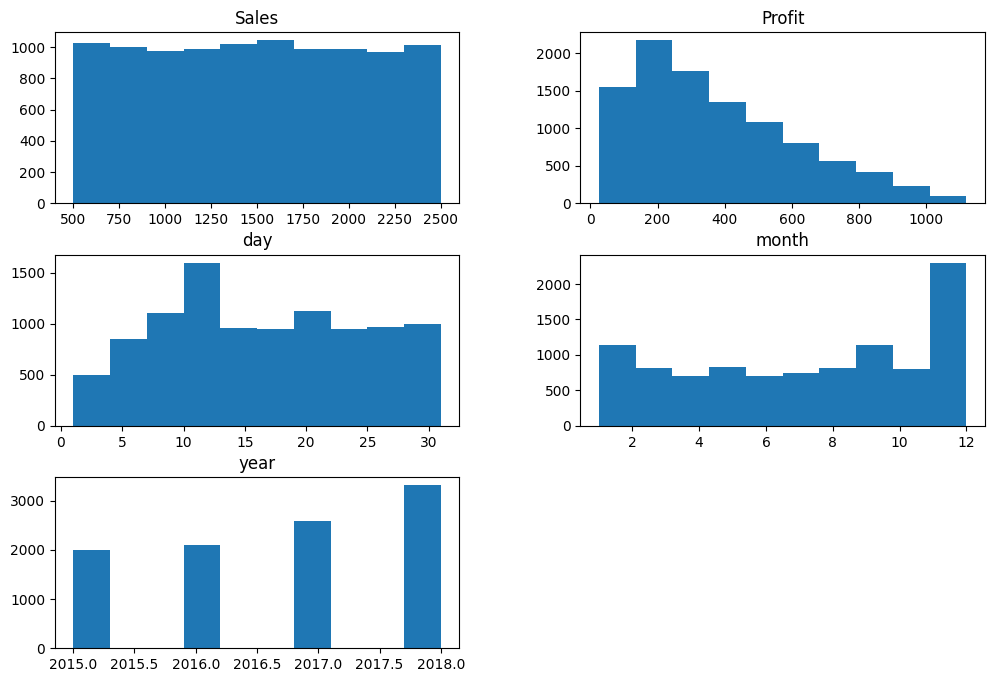

In [242]:
df.hist(figsize=(12,8),grid=False)